In [1]:
import json
from pathlib import Path
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import transforms, models

class ScentDataset(Dataset):
    def __init__(self, image_folder: str, json_file: str, transform=None, labels=None):
        self.image_folder = Path(image_folder)
        with open(json_file, "r", encoding="utf-8") as f:
            self.data = json.load(f)
        self.image_names = sorted(self.data.keys())
        self.transform = transform
        self.labels = labels or [
            "muddy", "earthy", "woody", "grassy", "floral",
            "rotten", "bloody", "musty", "sulfuric", "burnt",
            "chemical", "metallic", "clean", "oily", "dusty",
            "damp", "smoky", "salty", "sweet", "arcane", "no_scent"
        ]

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        image_path = self.image_folder / image_name
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        scent_data = self.data[image_name].get("scent_distribution", {})
        scent_vector = torch.tensor([scent_data.get(label, 0.0) for label in self.labels], dtype=torch.float32)
        if scent_vector.sum() > 0:
            scent_vector /= scent_vector.sum()
        return image, scent_vector


In [2]:
from torchvision.models import resnet50, ResNet50_Weights


class ScentPredictor(nn.Module):
    def __init__(self, num_labels=21):
        super(ScentPredictor, self).__init__()
        self.base_model = resnet50(weights=ResNet50_Weights.DEFAULT)
        self.base_model.fc = nn.Sequential(
            nn.Linear(self.base_model.fc.in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_labels),
            nn.Softmax(dim=1)
        )
    def forward(self, x):
        return self.base_model(x)

def topk_coverage(output, target, k=3, j=5):
    topk_target = torch.topk(target, k=k, dim=1).indices 
    topj_pred = torch.topk(output, k=j, dim=1).indices   

    correct_matches = 0
    for i in range(output.size(0)):
        match_count = sum(label in topj_pred[i] for label in topk_target[i])
        correct_matches += match_count / k 

    return correct_matches / output.size(0)


def cosine_similarity(output, target):
    sim = F.cosine_similarity(output, target, dim=1)
    return sim.mean().item()

def mean_absolute_error(output, target):
    return torch.abs(output - target).mean().item()

def binary_precision_recall_per_sample(output, target, threshold=0.05):
    B, C = output.shape
    precisions, recalls = [], []
    pred_bin = (output > threshold)
    targ_bin = (target > threshold)
    for i in range(B):
        pb = pred_bin[i]
        tb = targ_bin[i]
        tp = (pb & tb).sum().item()
        n_pred = pb.sum().item()
        n_targ = tb.sum().item()
        precisions.append(tp / (n_pred + 1e-9))
        recalls.append(tp / (n_targ + 1e-9))

    return sum(precisions) / B, sum(recalls) / B


image_folder_path = r"C:\Users\crazycyt\Desktop\1470\filtered_dataset"
json_file_path = "scent_labels_with_captions.json"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

dataset = ScentDataset(image_folder=image_folder_path, json_file=json_file_path, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ScentPredictor(num_labels=21).to(device)
criterion = nn.KLDivLoss(reduction="batchmean")
optimizer = optim.Adam(model.parameters(), lr=1e-5)
num_epochs = 20
lambda_l1 = 1e-3

In [4]:
checkpoint_path = "scent_model_checkpoint.pt"

if Path(checkpoint_path).exists():
    print("🔁 Loading model from checkpoint...")
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
else:
    print("🆕 No checkpoint found, training from scratch.")

🔁 Loading model from checkpoint...


In [4]:
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images, targets = images.to(device), targets.to(device)
        outputs = model(images)
        log_outputs = torch.log(outputs + 1e-9)
        # loss = criterion(log_outputs, targets)
        l1_penalty = torch.abs(outputs).sum(dim=1).mean()  
        loss = criterion(log_outputs, targets) + lambda_l1 * l1_penalty
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f"[Epoch {epoch+1}] Train Loss: {train_loss / len(train_loader):.4f}")

    model.eval()
    val_loss, top3, top5, cos_sim, mae, precision, recall = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
    with torch.no_grad():
        for images, targets in tqdm(val_loader, desc="Validation"):
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            log_outputs = torch.log(outputs + 1e-9)
            # loss = criterion(log_outputs, targets)
            l1_penalty = torch.abs(outputs).sum(dim=1).mean() 
            loss = criterion(log_outputs, targets) + lambda_l1 * l1_penalty
            val_loss += loss.item()
            top3 += topk_coverage(outputs, targets, k=3, j=3)
            top5 += topk_coverage(outputs, targets, k=5, j=5)
            cos_sim += cosine_similarity(outputs, targets)
            mae += mean_absolute_error(outputs, targets)
            p, r = binary_precision_recall_per_sample(outputs.cpu(), targets.cpu(), threshold=0.05)        
            precision += p
            recall    += r
            
    batches = len(val_loader)
    print(f"[Epoch {epoch+1}] Val Loss: {val_loss / batches:.4f}")
    print(f"  Top-3 Acc: {top3 / batches:.4f} | Top-5 Acc: {top5 / batches:.4f} | Cos Sim: {cos_sim / batches:.4f}")
    print(f"  Mean Absolute Error: {mae / batches:.4f}")
    print(f"  Binary Precision: {precision / batches:.4f}")
    print(f"  Binary Recall: {recall / batches:.4f}")

checkpoint_path = "scent_model_checkpoint.pt"
torch.save(model.state_dict(), checkpoint_path)
print(f"💾 Saved model to {checkpoint_path}")


Epoch 1/20 - Training: 100%|███████████████████████████████████████████████████████████| 67/67 [01:50<00:00,  1.64s/it]


[Epoch 1] Train Loss: 2.0929


Validation: 100%|██████████████████████████████████████████████████████████████████████| 17/17 [00:26<00:00,  1.57s/it]


[Epoch 1] Val Loss: 1.7676
  Top-3 Acc: 0.5413 | Top-5 Acc: 0.5338 | Cos Sim: 0.5196
  Mean Absolute Error: 0.0762
  Binary Precision: 0.3741
  Binary Recall: 0.7102


Epoch 2/20 - Training: 100%|███████████████████████████████████████████████████████████| 67/67 [01:41<00:00,  1.51s/it]


[Epoch 2] Train Loss: 1.4266


Validation: 100%|██████████████████████████████████████████████████████████████████████| 17/17 [00:26<00:00,  1.53s/it]


[Epoch 2] Val Loss: 1.1733
  Top-3 Acc: 0.5811 | Top-5 Acc: 0.6431 | Cos Sim: 0.7120
  Mean Absolute Error: 0.0566
  Binary Precision: 0.6071
  Binary Recall: 0.6943


Epoch 3/20 - Training: 100%|███████████████████████████████████████████████████████████| 67/67 [01:39<00:00,  1.48s/it]


[Epoch 3] Train Loss: 1.0139


Validation: 100%|██████████████████████████████████████████████████████████████████████| 17/17 [00:25<00:00,  1.51s/it]


[Epoch 3] Val Loss: 1.0537
  Top-3 Acc: 0.5897 | Top-5 Acc: 0.7022 | Cos Sim: 0.7319
  Mean Absolute Error: 0.0507
  Binary Precision: 0.6974
  Binary Recall: 0.7266


Epoch 4/20 - Training: 100%|███████████████████████████████████████████████████████████| 67/67 [01:37<00:00,  1.46s/it]


[Epoch 4] Train Loss: 0.8595


Validation: 100%|██████████████████████████████████████████████████████████████████████| 17/17 [00:25<00:00,  1.50s/it]


[Epoch 4] Val Loss: 0.9669
  Top-3 Acc: 0.6025 | Top-5 Acc: 0.7203 | Cos Sim: 0.7476
  Mean Absolute Error: 0.0468
  Binary Precision: 0.7024
  Binary Recall: 0.7646


Epoch 5/20 - Training: 100%|███████████████████████████████████████████████████████████| 67/67 [01:38<00:00,  1.48s/it]


[Epoch 5] Train Loss: 0.7650


Validation: 100%|██████████████████████████████████████████████████████████████████████| 17/17 [00:24<00:00,  1.46s/it]


[Epoch 5] Val Loss: 0.9126
  Top-3 Acc: 0.6170 | Top-5 Acc: 0.7317 | Cos Sim: 0.7580
  Mean Absolute Error: 0.0446
  Binary Precision: 0.6907
  Binary Recall: 0.7896


Epoch 6/20 - Training: 100%|███████████████████████████████████████████████████████████| 67/67 [01:40<00:00,  1.50s/it]


[Epoch 6] Train Loss: 0.6892


Validation: 100%|██████████████████████████████████████████████████████████████████████| 17/17 [00:26<00:00,  1.54s/it]


[Epoch 6] Val Loss: 0.8668
  Top-3 Acc: 0.6225 | Top-5 Acc: 0.7328 | Cos Sim: 0.7681
  Mean Absolute Error: 0.0423
  Binary Precision: 0.6871
  Binary Recall: 0.8024


Epoch 7/20 - Training: 100%|███████████████████████████████████████████████████████████| 67/67 [01:36<00:00,  1.44s/it]


[Epoch 7] Train Loss: 0.6319


Validation: 100%|██████████████████████████████████████████████████████████████████████| 17/17 [00:25<00:00,  1.52s/it]


[Epoch 7] Val Loss: 0.8307
  Top-3 Acc: 0.6234 | Top-5 Acc: 0.7328 | Cos Sim: 0.7782
  Mean Absolute Error: 0.0407
  Binary Precision: 0.6902
  Binary Recall: 0.8187


Epoch 8/20 - Training: 100%|███████████████████████████████████████████████████████████| 67/67 [01:39<00:00,  1.48s/it]


[Epoch 8] Train Loss: 0.5877


Validation: 100%|██████████████████████████████████████████████████████████████████████| 17/17 [00:26<00:00,  1.56s/it]


[Epoch 8] Val Loss: 0.8048
  Top-3 Acc: 0.6209 | Top-5 Acc: 0.7328 | Cos Sim: 0.7867
  Mean Absolute Error: 0.0395
  Binary Precision: 0.6976
  Binary Recall: 0.8270


Epoch 9/20 - Training: 100%|███████████████████████████████████████████████████████████| 67/67 [01:43<00:00,  1.54s/it]


[Epoch 9] Train Loss: 0.5508


Validation: 100%|██████████████████████████████████████████████████████████████████████| 17/17 [00:28<00:00,  1.66s/it]


[Epoch 9] Val Loss: 0.7827
  Top-3 Acc: 0.6297 | Top-5 Acc: 0.7336 | Cos Sim: 0.7916
  Mean Absolute Error: 0.0383
  Binary Precision: 0.7049
  Binary Recall: 0.8290


Epoch 10/20 - Training: 100%|██████████████████████████████████████████████████████████| 67/67 [01:50<00:00,  1.65s/it]


[Epoch 10] Train Loss: 0.5139


Validation: 100%|██████████████████████████████████████████████████████████████████████| 17/17 [00:26<00:00,  1.58s/it]


[Epoch 10] Val Loss: 0.7625
  Top-3 Acc: 0.6336 | Top-5 Acc: 0.7339 | Cos Sim: 0.7972
  Mean Absolute Error: 0.0369
  Binary Precision: 0.7142
  Binary Recall: 0.8286


Epoch 11/20 - Training: 100%|██████████████████████████████████████████████████████████| 67/67 [01:39<00:00,  1.49s/it]


[Epoch 11] Train Loss: 0.4859


Validation: 100%|██████████████████████████████████████████████████████████████████████| 17/17 [00:26<00:00,  1.58s/it]


[Epoch 11] Val Loss: 0.7478
  Top-3 Acc: 0.6375 | Top-5 Acc: 0.7373 | Cos Sim: 0.8038
  Mean Absolute Error: 0.0361
  Binary Precision: 0.7250
  Binary Recall: 0.8344


Epoch 12/20 - Training: 100%|██████████████████████████████████████████████████████████| 67/67 [01:41<00:00,  1.52s/it]


[Epoch 12] Train Loss: 0.4601


Validation: 100%|██████████████████████████████████████████████████████████████████████| 17/17 [00:26<00:00,  1.59s/it]


[Epoch 12] Val Loss: 0.7288
  Top-3 Acc: 0.6458 | Top-5 Acc: 0.7403 | Cos Sim: 0.8090
  Mean Absolute Error: 0.0350
  Binary Precision: 0.7441
  Binary Recall: 0.8410


Epoch 13/20 - Training: 100%|██████████████████████████████████████████████████████████| 67/67 [01:41<00:00,  1.51s/it]


[Epoch 13] Train Loss: 0.4332


Validation: 100%|██████████████████████████████████████████████████████████████████████| 17/17 [00:26<00:00,  1.54s/it]


[Epoch 13] Val Loss: 0.7175
  Top-3 Acc: 0.6530 | Top-5 Acc: 0.7447 | Cos Sim: 0.8145
  Mean Absolute Error: 0.0345
  Binary Precision: 0.7394
  Binary Recall: 0.8389


Epoch 14/20 - Training: 100%|██████████████████████████████████████████████████████████| 67/67 [01:42<00:00,  1.53s/it]


[Epoch 14] Train Loss: 0.4161


Validation: 100%|██████████████████████████████████████████████████████████████████████| 17/17 [00:26<00:00,  1.54s/it]


[Epoch 14] Val Loss: 0.7052
  Top-3 Acc: 0.6571 | Top-5 Acc: 0.7550 | Cos Sim: 0.8187
  Mean Absolute Error: 0.0334
  Binary Precision: 0.7446
  Binary Recall: 0.8421


Epoch 15/20 - Training: 100%|██████████████████████████████████████████████████████████| 67/67 [01:40<00:00,  1.51s/it]


[Epoch 15] Train Loss: 0.3932


Validation: 100%|██████████████████████████████████████████████████████████████████████| 17/17 [00:26<00:00,  1.54s/it]


[Epoch 15] Val Loss: 0.6969
  Top-3 Acc: 0.6654 | Top-5 Acc: 0.7575 | Cos Sim: 0.8211
  Mean Absolute Error: 0.0330
  Binary Precision: 0.7577
  Binary Recall: 0.8423


Epoch 16/20 - Training: 100%|██████████████████████████████████████████████████████████| 67/67 [01:40<00:00,  1.51s/it]


[Epoch 16] Train Loss: 0.3771


Validation: 100%|██████████████████████████████████████████████████████████████████████| 17/17 [00:26<00:00,  1.56s/it]


[Epoch 16] Val Loss: 0.7032
  Top-3 Acc: 0.6622 | Top-5 Acc: 0.7725 | Cos Sim: 0.8220
  Mean Absolute Error: 0.0318
  Binary Precision: 0.7626
  Binary Recall: 0.8381


Epoch 17/20 - Training: 100%|██████████████████████████████████████████████████████████| 67/67 [01:40<00:00,  1.50s/it]


[Epoch 17] Train Loss: 0.3664


Validation: 100%|██████████████████████████████████████████████████████████████████████| 17/17 [00:26<00:00,  1.55s/it]


[Epoch 17] Val Loss: 0.6842
  Top-3 Acc: 0.6658 | Top-5 Acc: 0.7706 | Cos Sim: 0.8267
  Mean Absolute Error: 0.0319
  Binary Precision: 0.7680
  Binary Recall: 0.8414


Epoch 18/20 - Training: 100%|██████████████████████████████████████████████████████████| 67/67 [01:38<00:00,  1.47s/it]


[Epoch 18] Train Loss: 0.3518


Validation: 100%|██████████████████████████████████████████████████████████████████████| 17/17 [00:25<00:00,  1.49s/it]


[Epoch 18] Val Loss: 0.6803
  Top-3 Acc: 0.6658 | Top-5 Acc: 0.7788 | Cos Sim: 0.8271
  Mean Absolute Error: 0.0319
  Binary Precision: 0.7653
  Binary Recall: 0.8440


Epoch 19/20 - Training: 100%|██████████████████████████████████████████████████████████| 67/67 [01:38<00:00,  1.46s/it]


[Epoch 19] Train Loss: 0.3412


Validation: 100%|██████████████████████████████████████████████████████████████████████| 17/17 [00:25<00:00,  1.50s/it]


[Epoch 19] Val Loss: 0.6772
  Top-3 Acc: 0.6732 | Top-5 Acc: 0.7793 | Cos Sim: 0.8287
  Mean Absolute Error: 0.0315
  Binary Precision: 0.7693
  Binary Recall: 0.8482


Epoch 20/20 - Training: 100%|██████████████████████████████████████████████████████████| 67/67 [01:40<00:00,  1.50s/it]


[Epoch 20] Train Loss: 0.3326


Validation: 100%|██████████████████████████████████████████████████████████████████████| 17/17 [00:25<00:00,  1.53s/it]

[Epoch 20] Val Loss: 0.6680
  Top-3 Acc: 0.6697 | Top-5 Acc: 0.7870 | Cos Sim: 0.8298
  Mean Absolute Error: 0.0319
  Binary Precision: 0.7485
  Binary Recall: 0.8533
💾 Saved model to scent_model_checkpoint.pt


In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def generate_gradcam(model, image_tensor, class_idx, target_layer="layer4"):
    model.eval()
    image_tensor = image_tensor.unsqueeze(0).to(device)

    activations = {}
    def forward_hook(module, input, output):
        activations["value"] = output

    gradients = {}
    def backward_hook(module, grad_input, grad_output):
        gradients["value"] = grad_output[0]

    target_module = dict([*model.base_model.named_modules()])[target_layer]
    forward_handle = target_module.register_forward_hook(forward_hook)
    backward_handle = target_module.register_backward_hook(backward_hook)

    output = model(image_tensor)
    score = output[0, class_idx]
    model.zero_grad()
    score.backward()

    grad = gradients["value"].detach().cpu().numpy()[0]
    act = activations["value"].detach().cpu().numpy()[0]
    weights = grad.mean(axis=(1, 2)) 
    cam = np.zeros(act.shape[1:], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * act[i]

    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (224, 224))
    cam = cam - np.min(cam)
    cam = cam / np.max(cam)
    
    forward_handle.remove()
    backward_handle.remove()

    return cam, output[0].detach().cpu().numpy()


def show_gradcam(image_path, model, label_name, label_to_index, transform, device="cuda"):

    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    cam, preds = generate_gradcam(model, input_tensor[0], label_to_index[label_name])


    img_np   = np.array(image.resize((224, 224)))

    heatmap_bgr = cv2.applyColorMap((cam * 255).astype(np.uint8), cv2.COLORMAP_JET)
    heatmap     = cv2.cvtColor(heatmap_bgr, cv2.COLOR_BGR2RGB)
    overlay = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)


    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(img_np)
    axes[0].set_title("Original Image")
    axes[0].axis("off")


    im1 = axes[1].imshow(cam, cmap="jet", vmin=0, vmax=1)
    axes[1].set_title(f"Grad-CAM (‘{label_name}’)")
    axes[1].axis("off")
    fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

    im2 = axes[2].imshow(overlay)
    axes[2].set_title("Overlay")
    axes[2].axis("off")

    sm = plt.cm.ScalarMappable(cmap="jet", norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    fig.colorbar(sm, ax=axes[2], fraction=0.046, pad=0.04, label="Grad-CAM intensity")

    plt.tight_layout()
    plt.show()

    print("Predicted scent distribution:")
    for lbl, score in zip(label_to_index.keys(), preds):
        print(f"  {lbl:8s}: {score:.3f}")



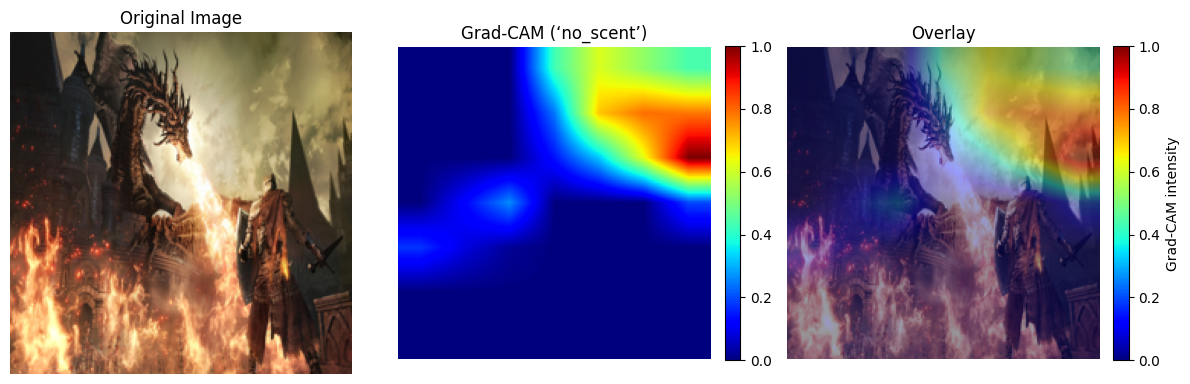

Predicted scent distribution:
  muddy   : 0.001
  earthy  : 0.046
  woody   : 0.037
  grassy  : 0.005
  floral  : 0.004
  rotten  : 0.003
  bloody  : 0.003
  musty   : 0.024
  sulfuric: 0.010
  burnt   : 0.359
  chemical: 0.011
  metallic: 0.003
  clean   : 0.000
  oily    : 0.003
  dusty   : 0.008
  damp    : 0.012
  smoky   : 0.314
  salty   : 0.001
  sweet   : 0.001
  arcane  : 0.018
  no_scent: 0.137


In [24]:
label_to_index = {label: idx for idx, label in enumerate(dataset.labels)}

image_path = r"C:\Users\crazycyt\Desktop\1470\filtered_dataset\Dark-Souls-III-Screenshot-012.jpg"
show_gradcam(image_path, model, label_name="no_scent", label_to_index=label_to_index, transform=transform)


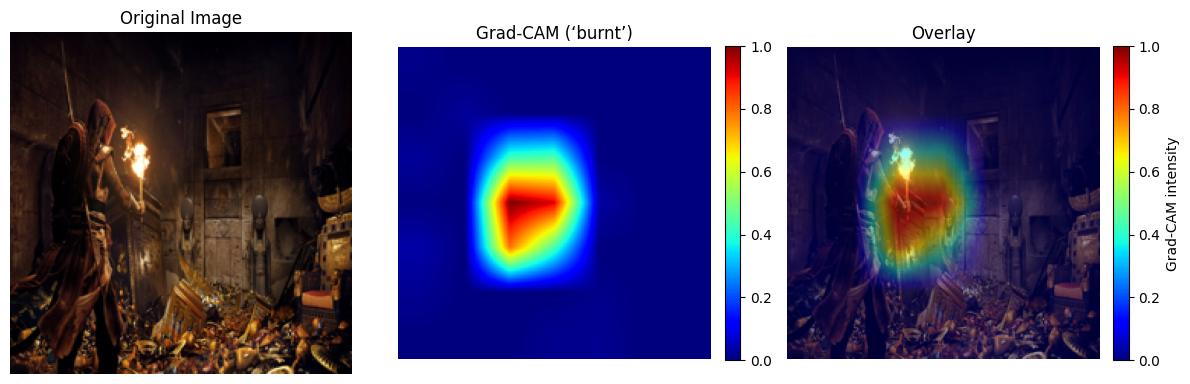

Predicted scent distribution:
  muddy   : 0.007
  earthy  : 0.045
  woody   : 0.038
  grassy  : 0.020
  floral  : 0.004
  rotten  : 0.006
  bloody  : 0.003
  musty   : 0.012
  sulfuric: 0.002
  burnt   : 0.208
  chemical: 0.005
  metallic: 0.002
  clean   : 0.001
  oily    : 0.002
  dusty   : 0.004
  damp    : 0.019
  smoky   : 0.484
  salty   : 0.001
  sweet   : 0.002
  arcane  : 0.001
  no_scent: 0.136


In [33]:
label_to_index = {label: idx for idx, label in enumerate(dataset.labels)}


image_path = r"C:\Users\crazycyt\Desktop\1470\filtered_dataset\Assassins-Creed-Origins-Screenshot-011.jpg"
show_gradcam(image_path, model, label_name="burnt", label_to_index=label_to_index, transform=transform)


In [5]:
from openai import OpenAI
client = OpenAI(api_key="")

In [15]:
def adjust_with_gpt(base_prediction: dict, user_prompt: str) -> dict:
    scent_list = ", ".join(base_prediction.keys())
    prompt = f"""
You are a game experience assistant that adjusts scent distributions based on user preference.
Given the scent categories: [{scent_list}]
And a predicted distribution: {json.dumps(base_prediction, indent=2)}
Moderately Adjust the distribution according to this user preference: "{user_prompt}"
Keep the output format as a JSON object with keys from the original list and values summing to 1.
Only use the keys in the list. No explanation.
"""

    try:
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[{"role": "user", "content": prompt}],
            temperature=0.3
        )
        result = response.choices[0].message.content
        adjusted = json.loads(result.strip().split("```")[-1] if "```" in result else result)
        return adjusted

    except Exception as e:
        print("⚠️ GPT adjustment failed:", e)
        return base_prediction


In [22]:
sample_img, _ = dataset[3]
sample_img = sample_img.unsqueeze(0).to(device)
with torch.no_grad():
    raw_output = model(sample_img).squeeze().cpu().numpy()

label_names = dataset.labels
base_prediction = {label: float(round(p, 4)) for label, p in zip(label_names, raw_output)}
user_text = "Avoid pungent smells. Prefer natural ones."

adjusted = adjust_with_gpt(base_prediction, user_text)

print("Base prediction:", base_prediction)
print("Adjusted prediction:", adjusted)


🔮 Base prediction: {'muddy': 0.01889999955892563, 'earthy': 0.15119999647140503, 'woody': 0.1518000066280365, 'grassy': 0.10209999978542328, 'floral': 0.011800000444054604, 'rotten': 0.008299999870359898, 'bloody': 0.007499999832361937, 'musty': 0.016899999231100082, 'sulfuric': 0.0034000000450760126, 'burnt': 0.06279999762773514, 'chemical': 0.004999999888241291, 'metallic': 0.0031999999191612005, 'clean': 0.0026000000070780516, 'oily': 0.002899999963119626, 'dusty': 0.009100000374019146, 'damp': 0.02810000069439411, 'smoky': 0.08730000257492065, 'salty': 0.0020000000949949026, 'sweet': 0.0032999999821186066, 'arcane': 0.0027000000700354576, 'no_scent': 0.3188999891281128}
🎯 Adjusted prediction: {'muddy': 0.0189, 'earthy': 0.1512, 'woody': 0.1518, 'grassy': 0.1021, 'floral': 0.0118, 'rotten': 0.0083, 'bloody': 0.0075, 'musty': 0.0169, 'sulfuric': 0.0034, 'burnt': 0.0628, 'chemical': 0.005, 'metallic': 0.0032, 'clean': 0.0026, 'oily': 0.0029, 'dusty': 0.0091, 'damp': 0.0281, 'smoky': 0